In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Lambda
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa

import numpy as np
import math
import matplotlib.pyplot as plt
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from data.pamap2.pamap2 import create_pamap2
from other_models.attention import har_model
from other_models.attention.attentive_pooling import AttentionWithContext

from tensorflow.keras.utils import to_categorical

In [2]:
def create_dataset(name, data_type):
    print("creating dataset")
    if name == "pamap2":
        if data_type == "frequency_100":
            x_train, y_train = create_pamap2(data="frequency_100")
            y_train = to_categorical(y_train, len(np.unique(y_train)))
        elif data_type == "nooverlap":
            x_train, y_train = create_pamap2(data="nooverlap")
            y_train = to_categorical(y_train, len(np.unique(y_train)))            

    # 80%, 10%, 10% respectively in train, val, test dataset
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)

    return x_train, y_train, x_val, y_val, x_test, y_test

In [3]:
secs = time.time()
tm = time.localtime(secs)

time_string = time.strftime('%Y%m%d%I%M%S', tm)
time_int = int(time_string) % (2**32 - 1)
time_string = str(time_int)
print('random_state : ' , time_int)

random_state :  3039482


In [4]:
def create_model(n_timesteps, n_features, n_outputs, _dff=512, d_model=128, nh=4, dropout_rate=0.2, use_pe=True):
    attention = har_model.create_model(100, 18, _dff=256, d_model=128, nh=4, dropout_rate=0.2, use_pe=False)

    inputs = tf.keras.layers.Input(shape=(n_timesteps, n_features,))

    output = attention(inputs)
    x = tf.keras.layers.Dense(n_outputs * 4, activation='relu')(output)
    x = tf.keras.layers.Dropout(0.2)(x)
    predictions = tf.keras.layers.Dense(n_outputs, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)

    return model

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

dataset_name = "pamap2"
data_type = "nooverlap"
x_train, y_train, x_val, y_val, x_test, y_test = create_dataset(name=dataset_name, data_type=data_type)

print("x_train.shape : ", x_train.shape, "y_train.shape: ", y_train.shape)
print("x_val.shape   : ", x_val.shape,    "y_val.shape: ", y_val.shape)
print("x_test.shape  : ", x_test.shape,   "y_test.shape: ", y_test.shape)

creating dataset
/home/dongi/har/HAR_Contrastive_loss/nooverlap
x_train.shape :  (15502, 100, 18) y_train.shape:  (15502, 12)
x_val.shape   :  (1938, 100, 18) y_val.shape:  (1938, 12)
x_test.shape  :  (1938, 100, 18) y_test.shape:  (1938, 12)


In [6]:
# batch = 64
# epochs = 100
# learning_rate = 0.005

batch = 128
epochs = 100
learning_rate = 0.005

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')

In [7]:
model = create_model(100, 18, 12, use_pe=True)
model.summary()
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch, verbose=1, validation_data=(x_val, y_val), callbacks=[reduce_lr_loss, earlyStopping])

2022-07-09 18:43:44.318307: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-09 18:43:45.026031: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20657 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:56:00.0, compute capability: 8.6


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 18)]         0         
                                                                 
 transformer (Functional)    (None, 128)               285221    
                                                                 
 dense_12 (Dense)            (None, 48)                6192      
                                                                 
 dropout_4 (Dropout)         (None, 48)                0         
                                                                 
 dense_13 (Dense)            (None, 12)                588       
                                                                 
Total params: 292,001
Trainable params: 292,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2022-07-09 18:43:51.853275: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-07-09 18:43:54.500639: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


122/122 [==============================] - 14s 42ms/step - loss: 0.9764 - accuracy: 0.7166 - val_loss: 0.8243 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 2/100
122/122 [==============================] - 5s 40ms/step - loss: 0.5308 - accuracy: 0.8574 - val_loss: 1.6060 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 3/100
122/122 [==============================] - 5s 42ms/step - loss: 0.4567 - accuracy: 0.8751 - val_loss: 0.5461 - val_accuracy: 0.8545 - lr: 0.0010
Epoch 4/100
122/122 [==============================] - 5s 38ms/step - loss: 0.3922 - accuracy: 0.8926 - val_loss: 0.3869 - val_accuracy: 0.9009 - lr: 0.0010
Epoch 5/100
122/122 [==============================] - 5s 39ms/step - loss: 0.3587 - accuracy: 0.8987 - val_loss: 0.3389 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 6/100
122/122 [==============================] - 5s 42ms/step - loss: 0.3331 - accuracy: 0.9074 - val_loss: 0.3264 - val_accuracy: 0.9004 - lr: 0.0010
Epoch 7/100
122/122 [==============================] - 5s 42ms/step -

In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [13]:
train_max_epoch = max(range(len(history.history['accuracy'])), key=lambda i: history.history['accuracy'][i])
valid_max_epoch = max(range(len(history.history['val_accuracy'])), key=lambda i: history.history['val_accuracy'][i])

print(f"maximum train acc : [{train_max_epoch}th] [t] {max(history.history['accuracy'])} [v] {history.history['val_accuracy'][train_max_epoch]}")
# print(f)
print(f"maximum valid acc : [{valid_max_epoch}th] [t] {history.history['accuracy'][valid_max_epoch]} [v] {max(history.history['val_accuracy'])}")

test_results = model.evaluate(x_test, y_test)
print("Test Loss & Test Accuracy")
print(test_results)

y_pred = model.predict([x_test])
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
score = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average="macro")
print("f1 score  : ", score)
print("MATRIX")
print(matrix)

maximum train acc : [16th] [t] 0.9642626643180847 [v] 0.9272446036338806
maximum valid acc : [14th] [t] 0.9589084982872009 [v] 0.9303405284881592
61/61 [==============================] - 2s 16ms/step - loss: 0.2980 - accuracy: 0.9340
Test Loss & Test Accuracy
[0.29800504446029663, 0.9339525103569031]
f1 score  :  0.9330485642815994
MATRIX
[[183   0   4   0   0   0   0   2   0   2   1   0]
 [  0 172   6   0   0   0   0   4   0   1   2   0]
 [  0   0 182   0   0   0   1   1   0   1   5   0]
 [  0   0   2 228   0   0   1   3   2   1   2   0]
 [  0   0   1   2  95   0   0   0   0   0   0   0]
 [  0   0   1   0   0 157   0   0   1   1   4   0]
 [  0   1   4   0   0   0 181   1   1   0   0   0]
 [  0   0   3   2   0   0   0 108   0   1   2   0]
 [  0   0   8   2   0   1   1   3  83   1   5   0]
 [  1   1   4   1   0   3   0   0   1 153  10   1]
 [  0   1   4   0   0   0   3   0   0   6 223   1]
 [  0   0   0   0   0   1   0   1   0   1   1  45]]


[PRINTING GRAPH]


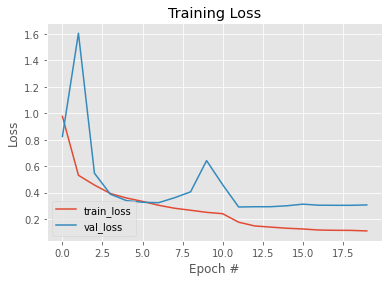

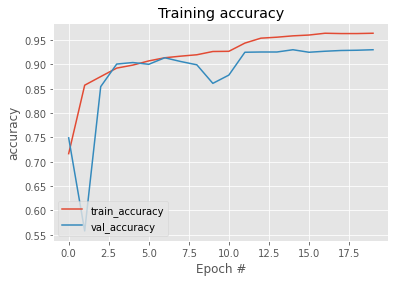

In [10]:
import matplotlib.pyplot as plt
def plot_training_loss(H, plotPath):
    	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	if plotPath is not None:
		plt.savefig(plotPath)
	else:
		plt.show()

def plot_training_acc(H, plotPath):
    	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["accuracy"], label="train_accuracy")
	plt.plot(H.history["val_accuracy"], label="val_accuracy")
	plt.title("Training accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("accuracy")
	plt.legend(loc="lower left")
	if plotPath is not None:
		plt.savefig(plotPath)
	else:
		plt.show()

print("[PRINTING GRAPH]")
plot_training_loss(history, None)
plot_training_acc(history, None)